In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import random
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
# define the nonlinearity and kernel
s2 = 0.5
n = 200 #number of particle
sigma1=4
sigma2=4
# expect xs to be [n,dim]
def phi(xs,ys,s2s):
    return torch.exp(-(xs-ys)**2/(2.*s2s))/(np.sqrt(2*np.pi*s2s))
    
def fn(xs, cs, ys, s2s):
    return torch.sum(cs * phi(xs,ys,s2s), dim=1, keepdim=True) / cs.shape[0]

In [3]:
# simple target function
y_fs = torch.tensor([-2.,0,2.])
s2_fs = torch.tensor([0.5,1,0.5])
c_fs = torch.tensor([1.,-2.,1])

def f(xs):
    return fn(xs, c_fs, y_fs, s2_fs)

def Cf(ys, cs, s2s):
    return torch.mean(cs)

In [4]:
def Foriginal(ys):
    return fn(ys, c_fs, y_fs, s2s)

def dForiginal(ys):
    return -torch.sum(c_fs * (ys-y_fs) *  phi(y_fs, ys, s2s) / s2s, dim=1, keepdim=True)/c_fs.shape[0]

# interaction
def Koriginal(ys, zs):
    return torch.exp(-(ys-zs)**2/(4.*s2))/(2.*np.sqrt(np.pi*s2))

def dKoriginal(ys, zs):
    return -(ys-zs)*torch.exp(-(ys-zs)**2/(4.*s2))/(4.*s2*np.sqrt(np.pi*s2))

In [5]:
def samplefunction(ys):
    return torch.abs(0.5*ys)

In [6]:
samplesize=500
batchsize=64
X=torch.rand([samplesize,1])*10-5
Xsample,indx=torch.sort(X,dim=0)
Ysample=f(Xsample)

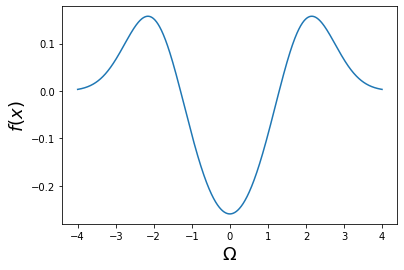

In [7]:
fig, ax = plt.subplots()
xs=torch.linspace(-4,4,1000).reshape(1000,1)
ax.set_ylabel(r"$f(x)$", fontsize=18)
ax.set_xlabel(r"$\Omega$", fontsize=18)
ax.plot(xs.numpy(), f(xs).numpy())

In [8]:
# single body potential
s2s = s2_fs + s2 # variances of the mixture

def F(ys,xsbatch,ysbatch):
    return -(torch.sum(phi(xsbatch,ys.t(), s2)*ysbatch,dim=0,keepdim=True)/batchsize).t()

def dF(ys,cs,xsbatch,ysbatch):
    return -torch.sum((xsbatch-ys.t())*phi(xsbatch,ys.t(),s2)*ysbatch*cs.t()/s2,dim=0,keepdim=True).t()/batchsize

# interaction
def K(ys,cs,xsbatch):
    return torch.sum(phi(xsbatch,ys.t(),s2)*torch.sum(phi(xsbatch,ys.t(),s2)*cs.t(),dim=1,keepdim=True),dim=0,keepdim=True).t()/(batchsize*n)

def dK(ys,cs,xsbatch):
    return -torch.sum(-phi(xsbatch,ys.t(),s2)*cs.t()*(1/s2)*(xsbatch-ys.t())*torch.sum(phi(xsbatch,ys.t(),s2)*cs.t(),dim=1,keepdim=True),dim=0,keepdim=True).t()/(batchsize*n)

In [9]:
def Kernel(ys,cs,sigma1,sigma2):
    return torch.exp(-(ys-ys.t())**2/(2.*sigma1))*torch.exp(-(cs-cs.t())**2/(2.*sigma2))

In [10]:
def Ly(ys,cs,xsbatch,ysbatch):
    return torch.sum(torch.mm((torch.sum(phi(xsbatch,ys.t(),s2)*cs.t(),dim=1,keepdim=True)/n-ysbatch)/n*phi(xsbatch,ys.t(),s2)*cs.t()*(xsbatch-ys.t())/s2,Kernel(ys,cs,sigma1,sigma2)),dim=0,keepdim=True).t()/batchsize

def Lc(ys,cs,xsbatch,ysbatch):
    return torch.sum(torch.mm((torch.sum(phi(xsbatch,ys.t(),s2)*cs.t(),dim=1,keepdim=True)/n-ysbatch)/n*phi(xsbatch,ys.t(),s2),Kernel(ys,cs,sigma1,sigma2)),dim=0,keepdim=True).t()/batchsize

In [11]:
def step_chargesnew(ys, cs, n,xsbatch,ysbatch, dt=5e-2):
    
    # ys_new = ys - dt * Ly(ys,cs,xsbatch,ysbatch)
    # cs_new = cs - dt * Lc(ys,cs,xsbatch,ysbatch)
    a=torch.mm((dF(ys,cs,xsbatch,ysbatch) + dK(ys,cs,xsbatch) ).t(),Kernel(ys,cs,sigma1,sigma2)).t()/n
    b=torch.mm((F(ys,xsbatch,ysbatch) + K(ys,cs,xsbatch) ).t(),Kernel(ys,cs,sigma1,sigma2)).t()/n
    ys_new = ys - dt * torch.mm((dF(ys,cs,xsbatch,ysbatch) + dK(ys,cs,xsbatch) ).t(),Kernel(ys,cs,sigma1,sigma2)).t()/n/np.sqrt(torch.norm(a)**2+torch.norm(b)**2)
    cs_new = cs - dt * torch.mm((F(ys,xsbatch,ysbatch) + K(ys,cs,xsbatch) ).t(),Kernel(ys,cs,sigma1,sigma2)).t()/n/np.sqrt(torch.norm(a)**2+torch.norm(b)**2)
    return ys_new, cs_new

In [12]:
def step_chargesoriginal(ys, cs, n,xsbatch,ysbatch, dt=5e-2):
    
    c=(dF(ys,cs,xsbatch,ysbatch) + dK(ys,cs,xsbatch) )
    d=(F(ys,xsbatch,ysbatch) + K(ys,cs,xsbatch) )
    ys_new = ys - dt * (dF(ys,cs,xsbatch,ysbatch) + dK(ys,cs,xsbatch) )
    cs_new = cs - dt * (F(ys,xsbatch,ysbatch) + K(ys,cs,xsbatch) )
    # ys_new = ys - dt * (dF(ys,cs,xsbatch,ysbatch) + dK(ys,cs,xsbatch) )
    # cs_new = cs - dt * (F(ys,xsbatch,ysbatch) + K(ys,cs,xsbatch) )
    return ys_new, cs_new

In [13]:
def step_chargesnoise(ys, cs, n,xsbatch,ysbatch, dt=5e-2):
    
    c=(dF(ys,cs,xsbatch,ysbatch) + dK(ys,cs,xsbatch) )
    d=(F(ys,xsbatch,ysbatch) + K(ys,cs,xsbatch) )
    V= cs*(F(ys,xsbatch,ysbatch)+K(ys,cs,xsbatch))
    zerotensor=torch.zeros(n,1)
    ys_new = ys - dt * c+sigma*torch.from_numpy(np.random.normal(0,np.sqrt(dt),(n,1)))*(torch.max((V-torch.mean(V)).float(),zerotensor.float()))
    cs_new = cs - dt * d+sigma*torch.from_numpy(np.random.normal(0,np.sqrt(dt),(n,1)))*(torch.max((V-torch.mean(V)).float(),zerotensor.float()))
    # ys_new = ys - dt * (dF(ys,cs,xsbatch,ysbatch) + dK(ys,cs,xsbatch) )
    # cs_new = cs - dt * (F(ys,xsbatch,ysbatch) + K(ys,cs,xsbatch) )
    return ys_new, cs_new

In [14]:
# gradient descent trajectory with noise(without nd)
def run_traj_noise(n, n_steps, ys, cs, dt=5e-3):
    if ys is None:
        ys = 4*torch.rand([n,1])-2
    if cs is None:
        cs = torch.randn(ys.shape)
    #traj = [(ys,cs)]
    traj = torch.zeros([n_steps, 2, n])
    for i in range(n_steps):

        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)   

        traj[i,0,:] = ys.flatten()
        traj[i,1,:] = cs.flatten()
        ys, cs = step_chargesnoise(ys, cs,n,xsbatch,ysbatch,dt=dt)
    return traj

In [15]:
# basic gradient descent trajectory
def run_traj(n, n_steps, ys, cs, dt=5e-3):
    if ys is None:
        ys = 4*torch.rand([n,1])-2
    if cs is None:
        cs = torch.randn(ys.shape)
    #traj = [(ys,cs)]
    traj = torch.zeros([n_steps, 2, n])
    for i in range(n_steps):
        # ys, cs = step_charges(ys, cs, n, dt=dt)
        #traj.append((ys,cs))

        # traj[i,0,:] = ys.flatten()
        # traj[i,1,:] = cs.flatten()

        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)   

        traj[i,0,:] = ys.flatten()
        traj[i,1,:] = cs.flatten()
        ys, cs = step_chargesoriginal(ys, cs,n,xsbatch,ysbatch,dt=dt)
    return traj

In [16]:
def make_animation(traj): 
    fig, [ax1,ax2] = plt.subplots(1,2,figsize=(8,4))
    ax1.set_xlim(-5,5)
    ax1.set_ylim(-3,3)
    l1, = ax1.plot([],[], "o")
    
    xs = torch.linspace(-5,5,100).reshape(100,1)
    ax2.set_ylabel(r"$f_n(x)$", fontsize=18)
    ax2.set_xlabel(r"$\Omega$", fontsize=18)
    ax2.set_xlim(-5,5)
    ax2.set_ylim(-0.75,0.75)
    ax2.plot(xs.numpy(), f(xs).numpy(), "k")
    l2, = ax2.plot([],[], "o-")
    

    def animate(i):
        if len(traj[0])>1:
            n = traj[0][0].shape[0]
            l1.set_data(traj[i][0].t().numpy(), traj[i][1].t().numpy())
            l2.set_data(xs, fn(xs, traj[i][1].reshape(n), traj[i][0].reshape(n), s2).numpy())
        else:
            n = traj[0].shape[0]
            l1.set_data(traj[i].numpy(), torch.zeros(n).numpy())
            l2.set_data(xs, fn(xs,torch.ones(n),traj[i].reshape(n),s2).numpy())

    return matplotlib.animation.FuncAnimation(fig, animate, frames=len(traj), interval=1)

In [17]:
def kill(ys, cs, kill_inds):
    survivor_inds = torch.tensor(list(set(range(ys.shape[0]))-set(kill_inds)), dtype=torch.long)
    ys = torch.index_select(ys,0,survivor_inds)
    cs = torch.index_select(cs,0,survivor_inds)
    return ys,cs

def run_traj_new(n, n_steps, ys, cs,alpha=1, dt=5e-2):
    if ys is None:
        ys = (4*torch.rand([n,1])-2)
    if cs is None:
        cs = torch.randn(ys.shape)
    traj = torch.zeros([n_steps, 2, n])
    total_pop = n
    for i in range(n_steps):
        #select sample
        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)   

        traj[i,0,:] = ys.flatten()
        traj[i,1,:] = cs.flatten()
        ys, cs = step_chargesnew(ys, cs,n,xsbatch,ysbatch,dt=dt)

        # select batch again for bd process
        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)
        
        cU = -cs*(F(ys,xsbatch,ysbatch)+K(ys,cs,xsbatch))
        
        kill_inds = []
        n_cloned = 0
        for i in range(ys.shape[0]):
            acUi = alpha *(cU[i,0]-1/n*torch.sum(cU))
            r = np.random.rand()
            if acUi < 0:
                if r < -acUi:
                    kill_inds.append(i)
      
            elif r < acUi:
                ys = torch.cat((ys,ys[i,:].reshape(1,1)))
                cs = torch.cat((cs,cs[i,:].reshape(1,1)))
                n_cloned+=1
                
        # now kill the particles on the kill list
        ys,cs = kill(ys,cs,kill_inds)

        # and resample to control population
        delta_n = n_cloned-len(kill_inds)
        if delta_n<0:
            clone_inds = torch.randint(n+delta_n, (-delta_n,), dtype=torch.long)
            ys = torch.cat((ys,torch.index_select(ys,0,clone_inds)))
            cs = torch.cat((cs,torch.index_select(cs,0,clone_inds)))
        if delta_n>0:
            kill_inds = (torch.randperm(ys.shape[0], dtype=torch.int)[:delta_n]).numpy()
            ys, cs = kill(ys,cs,kill_inds)
            

    # for i in range(n_steps-quench_steps, n_steps):
    #     traj[i,0,:] = ys.flatten()
    #     traj[i,1,:] = cs.flatten()
    #     ys, cs = step_charges(ys, cs,n,xsbatch,ysbatch,dt=dt)
        #traj.append((ys,cs))

            
    return traj

In [18]:
def run_traj_original(n, n_steps, ys, cs,alpha=1, dt=5e-2):
    if ys is None:
        ys = (4*torch.rand([n,1])-2)
    if cs is None:
        cs = torch.randn(ys.shape)
    traj = torch.zeros([n_steps, 2, n])
    total_pop = n
    for i in range(n_steps):
        #select sample
        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)   

        traj[i,0,:] = ys.flatten()
        traj[i,1,:] = cs.flatten()
        ys, cs = step_chargesoriginal(ys, cs,n,xsbatch,ysbatch,dt=dt)

        # select batch again for bd process
        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)
        
        cU = cs*(F(ys,xsbatch,ysbatch)+K(ys,cs,xsbatch))
        
        kill_inds = []
        n_cloned = 0
        for i in range(ys.shape[0]):
            rate = (cU[i,0]-1/n*torch.sum(cU))
            r = np.random.rand()
            if rate > 0:
                if r < 1-torch.exp(-dt*rate*alpha):
                    kill_inds.append(i)
      
            elif r < 1-torch.exp(dt*rate*alpha):
                ys = torch.cat((ys,ys[i,:].reshape(1,1)))
                cs = torch.cat((cs,cs[i,:].reshape(1,1)))
                n_cloned+=1
                
        # now kill the particles on the kill list
        ys,cs = kill(ys,cs,kill_inds)

        # and resample to control population
        delta_n = n_cloned-len(kill_inds)
        if delta_n<0:
            clone_inds = torch.randint(n+delta_n, (-delta_n,), dtype=torch.long)
            ys = torch.cat((ys,torch.index_select(ys,0,clone_inds)))
            cs = torch.cat((cs,torch.index_select(cs,0,clone_inds)))
        if delta_n>0:
            kill_inds = (torch.randperm(ys.shape[0], dtype=torch.int)[:delta_n]).numpy()
            ys, cs = kill(ys,cs,kill_inds)

    return traj

In [19]:
def run_traj_noise_bd(n, n_steps, ys, cs,alpha=1, dt=5e-2):
    if ys is None:
        ys = (4*torch.rand([n,1])-2)
    if cs is None:
        cs = torch.randn(ys.shape)
    traj = torch.zeros([n_steps, 2, n])
    total_pop = n
    for i in range(n_steps):
        #select sample
        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)   

        traj[i,0,:] = ys.flatten()
        traj[i,1,:] = cs.flatten()
        ys, cs = step_chargesnoise(ys, cs,n,xsbatch,ysbatch,dt=dt)

        # select batch again for bd process
        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)
        
        cU = cs*(F(ys,xsbatch,ysbatch)+K(ys,cs,xsbatch))
        
        kill_inds = []
        n_cloned = 0
        for i in range(ys.shape[0]):
            rate = (cU[i,0]-1/n*torch.sum(cU))
            r = np.random.rand()
            if rate > 0:
                if r < 1-torch.exp(-dt*rate*alpha):
                    kill_inds.append(i)
      
            elif r < 1-torch.exp(dt*rate*alpha):
                ys = torch.cat((ys,ys[i,:].reshape(1,1)))
                cs = torch.cat((cs,cs[i,:].reshape(1,1)))
                n_cloned+=1
                
        # now kill the particles on the kill list
        ys,cs = kill(ys,cs,kill_inds)

        # and resample to control population
        delta_n = n_cloned-len(kill_inds)
        if delta_n<0:
            clone_inds = torch.randint(n+delta_n, (-delta_n,), dtype=torch.long)
            ys = torch.cat((ys,torch.index_select(ys,0,clone_inds)))
            cs = torch.cat((cs,torch.index_select(cs,0,clone_inds)))
        if delta_n>0:
            kill_inds = (torch.randperm(ys.shape[0], dtype=torch.int)[:delta_n]).numpy()
            ys, cs = kill(ys,cs,kill_inds)

    return traj


In [20]:
def run_traj_newwithoutbd(n, n_steps, ys, cs, dt=5e-3):
    if ys is None:
        ys = 4*torch.rand([n,1])-2
    if cs is None:
        cs = torch.randn(ys.shape)
    #traj = [(ys,cs)]
    traj = torch.zeros([n_steps, 2, n])
    for i in range(n_steps):

        batchindex=random.sample(range(samplesize),batchsize)
        batchindex=torch.tensor(list(batchindex))
        xsbatch = torch.index_select(Xsample,0,batchindex)
        ysbatch = torch.index_select(Ysample,0,batchindex)   

        traj[i,0,:] = ys.flatten()
        traj[i,1,:] = cs.flatten()
        ys, cs = step_chargesnew(ys, cs,n,xsbatch,ysbatch,dt=dt)
    return traj

In [21]:
n_steps = 15000
ysinitial=4*torch.rand([n,1])-2
csinitial=torch.randn(ysinitial.shape)
sigma=10
traj_gd = run_traj(n, n_steps,ysinitial,csinitial,dt=1e-2)
traj_s1 = run_traj_original(n, n_steps, ysinitial, csinitial,alpha=5, dt=1e-2)
traj_s2 = run_traj_noise(n, n_steps,ysinitial,csinitial, dt=1e-2)
traj_s3 = run_traj_noise_bd(n, n_steps,ysinitial,csinitial,alpha=5, dt=1e-2)

In [22]:
Cf = 0.206/3
def err(traj):
    err_traj = []
    for ys,cs in traj:
        ys = ys.reshape(n,1)
        cs = cs.reshape(n,1)
        err_traj.append(torch.mean(Cf-cs*Foriginal(ys) + 0.5*cs*torch.mm(Koriginal(ys,ys.t()),cs)/n).numpy())
    return np.array(err_traj)

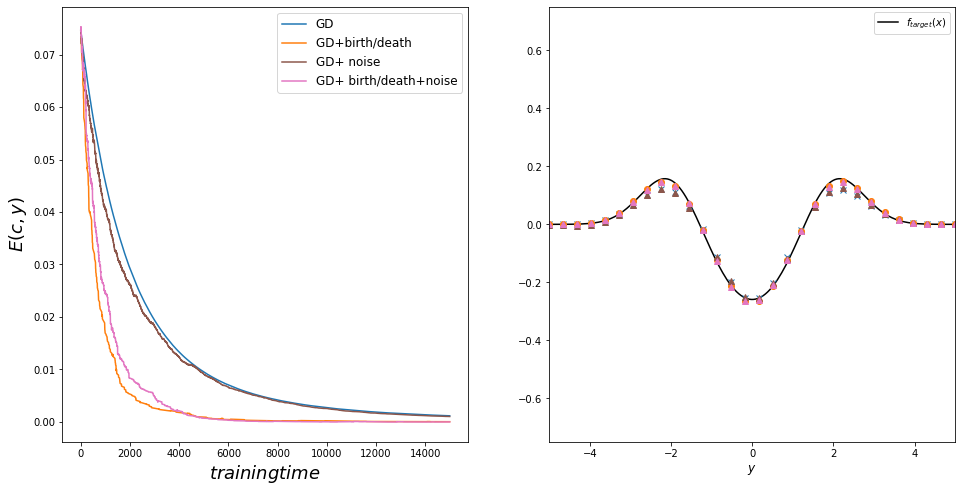

In [23]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(16,8))
ys = torch.linspace(-5,5,100).reshape([100,1])
ax1.set_ylabel(r"$E(c,y)$", fontsize=18)
ax1.set_xlabel(r"$training time$", fontsize=18)
ax1.plot(np.array(err(traj_gd)), label=r"GD",color=colors[0])
ax1.plot(err(traj_s1), label=r"GD+birth/death ",color=colors[1])
ax1.plot(err(traj_s2), label=r"GD+ noise", color=colors[5])
ax1.plot(err(traj_s3), label=r"GD+ birth/death+noise", color=colors[6])
ax1.legend(fontsize=12, loc=0)

ax2.set_xlabel(r"$y$", fontsize=12)
ax2.set_xlim(-5,5)
ax2.set_ylim(-0.75,0.75)
xs = torch.linspace(-5,5,200).reshape(200,1)
ax2.plot(xs.numpy(), f(xs).numpy(), "k", label=r"$f_{target}(x)$")
n = traj_gd[0][0].shape[0]
xs = torch.linspace(-5,5,30).reshape(30,1)
ax2.plot(xs.numpy(), fn(xs, traj_gd[-1][1].reshape(n), traj_gd[-1][0].reshape(n), s2).numpy(), "x", color=colors[0])
ax2.plot(xs.numpy(), fn(xs, traj_s1[-1][1].reshape(n), traj_s1[-1][0].reshape(n), s2).numpy(), "o", color=colors[1])
ax2.plot(xs.numpy(), fn(xs, traj_s2[-1][1].reshape(n), traj_s2[-1][0].reshape(n), s2).numpy(), "^", color=colors[5])
ax2.plot(xs.numpy(), fn(xs, traj_s3[-1][1].reshape(n), traj_s3[-1][0].reshape(n), s2).numpy(), "^", color=colors[6])
ax2.legend()
